# pyRootHair Demonstration ipynb 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

from numpy.typing import NDArray
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from skimage.transform import rotate, warp, PiecewiseAffineTransform
from scipy.ndimage import convolve
from scipy.spatial.distance import euclidean
from scipy.interpolate import CubicSpline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.cluster import KMeans

In [46]:
image = iio.imread('~/Images/Wheat/CSC_Images/Raw/karim_demo.png')
mask = iio.imread('~/Images/Wheat/CSC_Images/Masks/karim_demo_mask.png')

Text(0.5, 1.0, 'Binary Mask')

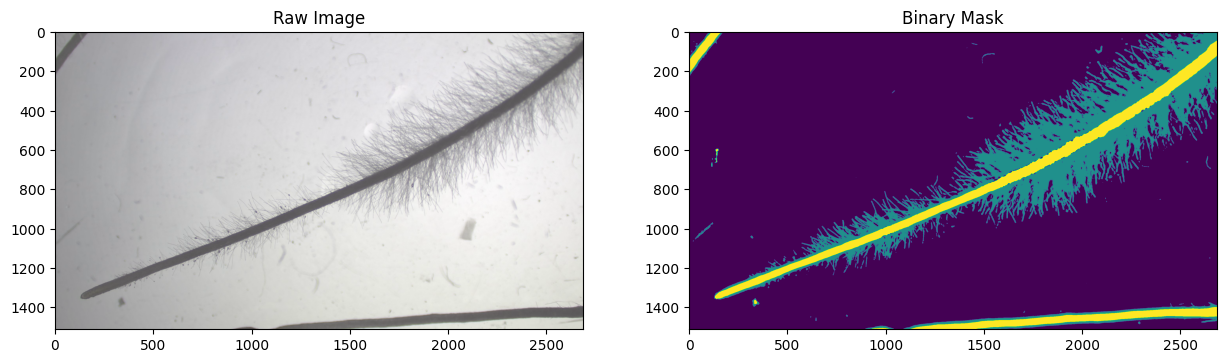

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(15,10))
ax[0].imshow(image)
ax[0].set_title('Raw Image')
ax[1].imshow(mask)
ax[1].set_title('Binary Mask')

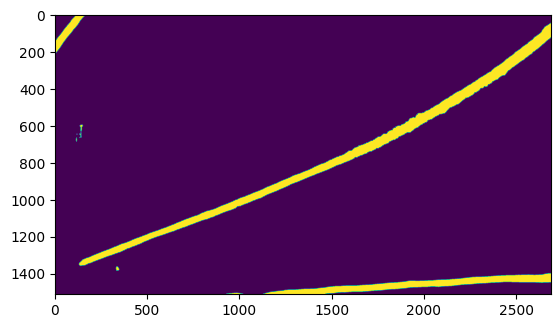

In [48]:
root_mask = (mask == 2)

plt.imshow(root_mask)

In [49]:
root_labeled_cleaned, root_count_cleaned = label(root_mask, connectivity=2, return_num=True) # re check num objects

def clean_root_chunk(mask) -> tuple['NDArray', list]:
        """
        Clean up each small section of the root mask by removing all but the largest area present
        """
        root_section_labeled, num_labels = label(mask, connectivity=2, return_num=True) # label the root mask
        
        if num_labels > 0:
            root_section_measured = regionprops(root_section_labeled) # measure the root section 
            max_label = max(root_section_measured, key=lambda x: x.area).label # get the label associated with the largest area in the measured section
            
            # mask out the smaller sections, retaining only the largest section
            clean_root_mask = root_section_labeled == max_label 
            root_section_labeled, _ = label(clean_root_mask, connectivity=2, return_num=True) # re label root 
            root_section_measured = regionprops(root_section_labeled) # re measure root section

            return root_section_labeled, root_section_measured

if root_count_cleaned > 1: # if more than 1 root is present    
    root_labeled_cleaned, count = clean_root_chunk(root_labeled_cleaned)

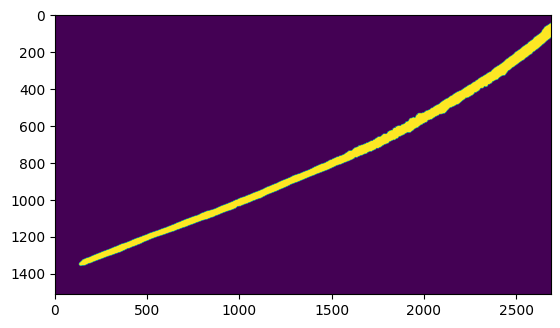

In [50]:
plt.imshow(root_labeled_cleaned)

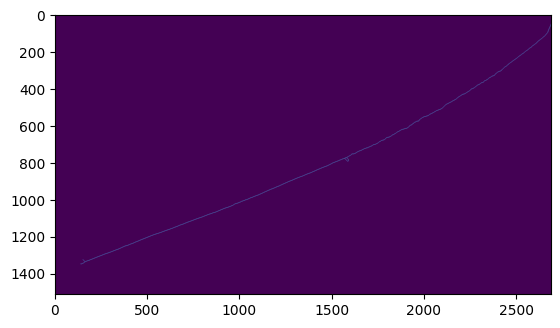

In [51]:
skeleton = skeletonize(root_labeled_cleaned)

skeleton_y, skeleton_x = np.nonzero(skeleton)

plt.imshow(skeleton)

In [52]:
t_range  = np.arange(len(skeleton_x))
x_spline = CubicSpline(t_range, skeleton_x)(t_range)
y_spline = CubicSpline(t_range, skeleton_y)(t_range)

merged_spline = np.array(list(zip(x_spline, y_spline)))
skeleton_start = int(min(y_spline))
skeleton_end = int(max(y_spline))

In [53]:
med_x, med_y = [], []
        
bin_size = 100
for start in range(skeleton_start, skeleton_end, bin_size):
    end = start + bin_size
    bin_y_val = [x[1] for x in merged_spline if start <= x[1] <= end]
    bin_x_val = [x[0] for x in merged_spline if start <= x[1] <= end]
    
    med_y.append(np.median(bin_y_val)) 
    med_x.append(np.median(bin_x_val))

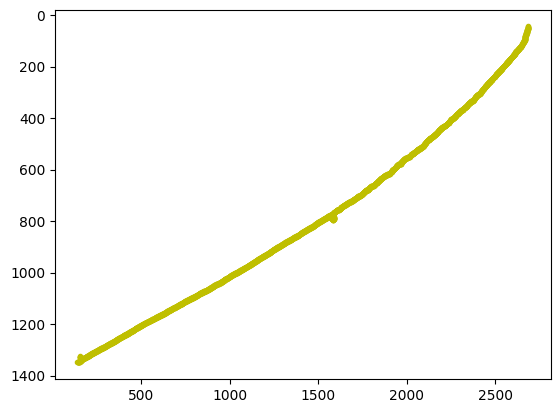

In [54]:
fig, ax = plt.subplots()
plt.plot(merged_spline[:,0], merged_spline[:,1], 'y.')
ax.yaxis.set_inverted(True)


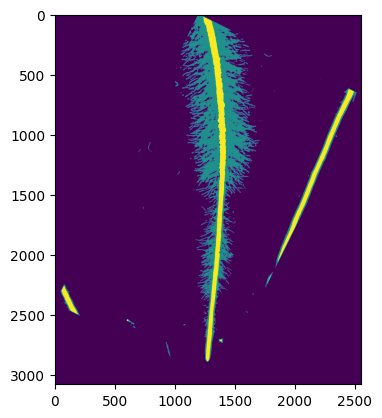

In [55]:
dy = max(med_y) - min(med_y)
dx = med_x[0] - med_x[-1]

angle = np.rad2deg(np.arctan(dx/dy))
    
rotated_mask = rotate(mask, angle, preserve_range=True, resize=True, mode='constant')

plt.imshow(rotated_mask)

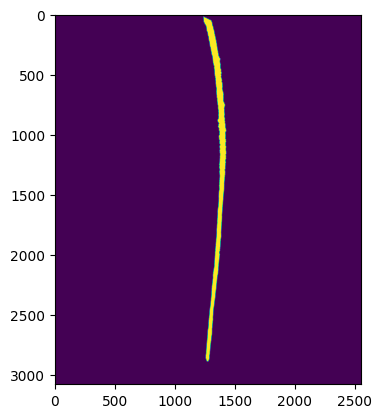

In [56]:
rotated_root_mask = (rotated_mask == 2)

clean_root_rotated_labeled, rotated_count = label(rotated_root_mask, connectivity=2, return_num=True)

if rotated_count > 1: # if more than 1 root is present    
    rotated_root_labeled_cleaned, new_count = clean_root_chunk(clean_root_rotated_labeled)

plt.imshow(rotated_root_labeled_cleaned)

In [57]:
skeleton_rotated = skeletonize(rotated_root_labeled_cleaned)

skeleton_y_rot, skeleton_x_rot = np.nonzero(skeleton_rotated)

t_range_rot  = np.arange(len(skeleton_x_rot))
x_spline_rot = CubicSpline(t_range_rot, skeleton_x_rot)(t_range_rot)
y_spline_rot = CubicSpline(t_range_rot, skeleton_y_rot)(t_range_rot)

merged_spline_rot = np.array(list(zip(x_spline_rot, y_spline_rot)))
skeleton_start_rot = int(min(y_spline_rot))
skeleton_end_rot = int(max(y_spline_rot))

med_x_rot, med_y_rot = [], []
        
bin_size = 100
for start in range(skeleton_start_rot, skeleton_end_rot, bin_size):
    end = start + bin_size
    bin_y_val_rot = [x[1] for x in merged_spline_rot if start <= x[1] <= end]
    bin_x_val_rot = [x[0] for x in merged_spline_rot if start <= x[1] <= end]
    
    med_y_rot.append(np.median(bin_y_val_rot)) 
    med_x_rot.append(np.median(bin_x_val_rot))



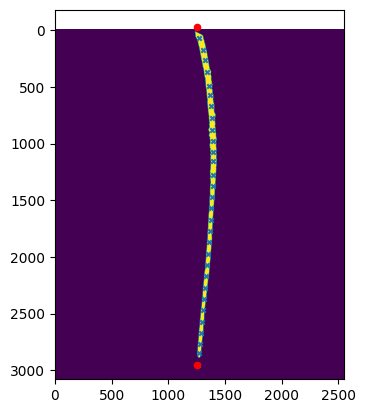

In [58]:
points = np.array(list(zip(med_x_rot, med_y_rot)))

first_point = points[0] 
second_point = points[1]

last_point = points[-1]
seclast_point = points[-2]

def generate_endpoints(pointA: list, pointB: list, length: int) -> tuple[float, float]:
    """
    Generate new end points
    """
    len_pApB = euclidean(pointA, pointB)
    n_x = pointA[0] + ((pointA[0]-pointB[0]) / len_pApB*length)
    n_y = pointA[1] + ((pointA[1]-pointB[1]) / len_pApB*length)

    return n_x, n_y

first_x, first_y = generate_endpoints(first_point, second_point, 100)
last_x, last_y = generate_endpoints(last_point, seclast_point, 100)

# Add new end points to the beginning/end of points array
points = np.vstack([[first_x, first_y], points])
points = np.vstack([points,[last_x, last_y]])

plt.imshow(rotated_root_labeled_cleaned)
plt.scatter(points[:,0], points[:,1], s=10, marker='x')
plt.scatter(points[:,0][0], points[:,1][0], color='red', s=20)
plt.scatter(points[:,0][0], points[:,1][-1], color='red', s=20)

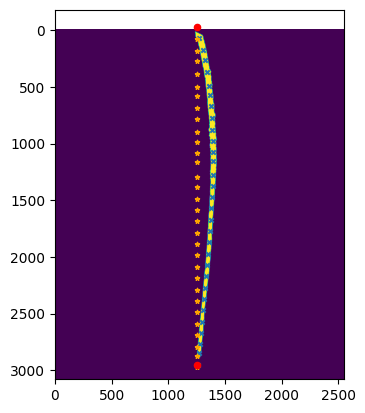

In [59]:
dist = [euclidean(x,y) for x,y in zip(points, points[1:])] # euclidean distance between each midline point
dist_lookup = list(zip(points[:-1],dist))

old_p = points[0]
new_p = old_p + (0, dist[0])
new_points = [old_p, new_p,]

# create new array to store co-ordinates of new points 
for x in dist_lookup[1:]:
    last_point = new_points[-1]
    _, dist = x

    length = euclidean(old_p, last_point)
    new_y_val = last_point[1] + ((last_point[1] - old_p[1]) / length*dist)
    new_points.append([old_p[0], new_y_val]) 

new_points = np.array(new_points)

plt.imshow(rotated_root_labeled_cleaned)
plt.scatter(points[:,0], points[:,1], s=10, marker='x')
plt.scatter(new_points[:,0], new_points[:,1], s=10, marker='*', color='orange')
plt.scatter(points[:,0][0], points[:,1][0], color='red', s=20)
plt.scatter(points[:,0][0], points[:,1][-1], color='red', s=20)


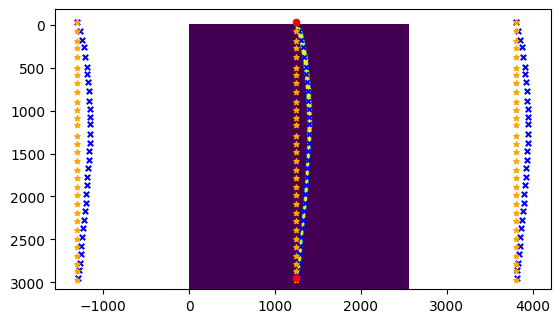

In [60]:
padding = rotated_mask.shape[1] 

old_buffer_coords = np.vstack([points+[padding,0], points+[-padding,0]])
new_buffer_coords = np.vstack([new_points+[padding,0], new_points+[-padding,0]])

plt.imshow(rotated_root_labeled_cleaned)
plt.scatter(points[:,0], points[:,1], s=10, marker='x', color='blue')
plt.scatter(new_points[:,0], new_points[:,1], s=15, marker='*', color='orange')
plt.scatter(old_buffer_coords[:,0], old_buffer_coords[:,1], s=15, marker='x', color='blue')
plt.scatter(new_buffer_coords[:,0], new_buffer_coords[:,1], s=15, marker='*', color='orange')
plt.scatter(points[:,0][0], points[:,1][0], color='red', s=20)
plt.scatter(points[:,0][0], points[:,1][-1], color='red', s=20)

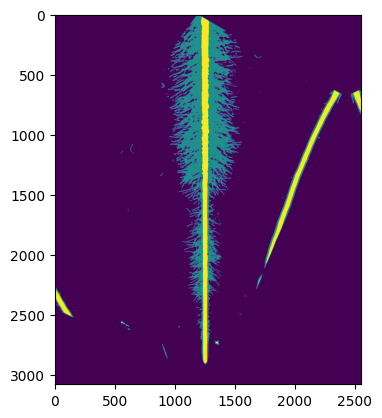

In [61]:
tform = PiecewiseAffineTransform()
tform.estimate(new_buffer_coords,old_buffer_coords)

straight_mask = warp(rotated_mask, tform, mode='symmetric')

plt.imshow(straight_mask)

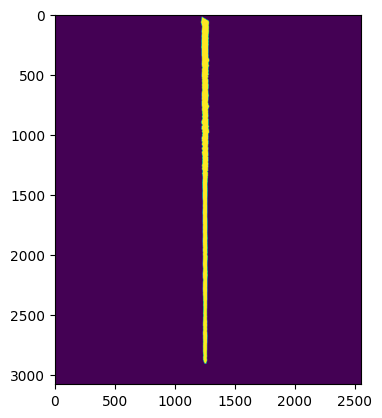

In [62]:
final_root_mask = (straight_mask > 1.7)

final_root_labeled, final_root_count = label(final_root_mask, connectivity=2, return_num=True)

if final_root_count > 1: # if more than 1 root is present    
    final_root_labeled, final_root_count = clean_root_chunk(final_root_labeled)

# final_labeled_root, _ = label(final_root_mask, connectivity=2, return_num=True)
root_measured = regionprops(final_root_labeled) # measure cleaned root
coords = [i.coords for i in root_measured][0] # get all coords of masked cleaned root
max_root_y_coord = max(coords[:,0]) # get max y-coord of cleaned root
image_height = straight_mask.shape[0] # get height of the image

if image_height - max_root_y_coord > 1: # if > 1 px difference between image height and max y of root
    found_tip = True 

fig, ax = plt.subplots()
ax.imshow(final_root_labeled)

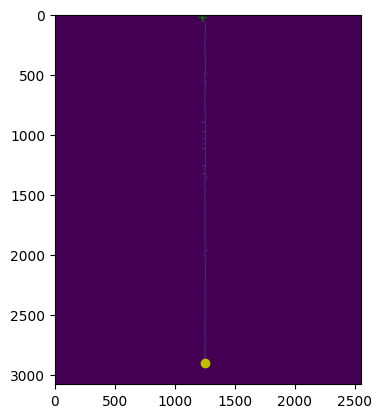

In [63]:
if found_tip:
    final_skeleton = skeletonize(final_root_labeled)
    kernel = np.array([[1,1,1], 
                        [1,2,1],  # each pixel in sliding window has value of 2 (2 x 1), while neighboring pixels have a value of 1 
                        [1,1,1]]) # define kernel that slides over each pixel in the rotated root skeleton.


    neighbours = convolve(final_skeleton.astype(int), kernel, mode='constant') # apply convolution to skeleton to find out which pixels have 1 neighbour
    endpoints = np.where(neighbours == 3) # edges only have 1 neighbour, so 2 + 1 = 3
    endpoints_list = list(zip(endpoints[0], endpoints[1])) # store results in paired list 
    root_tip = max(endpoints_list, key = lambda x: x[0]) # get coords where y-coord is max (bottom of root - assuming root growing downwards)
    root_start = min(endpoints_list, key=lambda x: x[0]) # coords of where root starts
    root_tip_y, root_tip_x = root_tip 
    root_start_y, root_start_x = root_start


plt.imshow(final_skeleton)
plt.plot(root_tip_x, root_tip_y, 'yo')
plt.plot(root_start_x, root_start_y, 'g+')

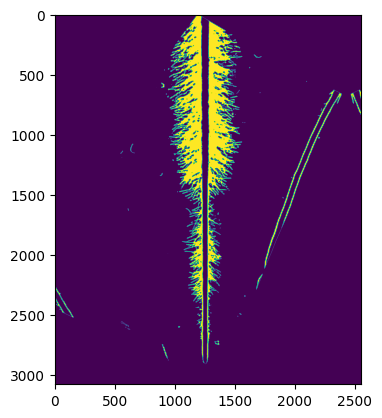

In [64]:
def extract_root(root_mask):

    root_labeled_cleaned, root_count_cleaned = label(root_mask, connectivity=2, return_num=True) # re check num objects

    if root_count_cleaned > 1: # if more than 1 root is present    
        root_labeled_cleaned, _ = clean_root_chunk(root_mask)

    return root_labeled_cleaned


rh_mask = (straight_mask > 0.4) & (straight_mask <= 1.4)

plt.imshow(rh_mask)

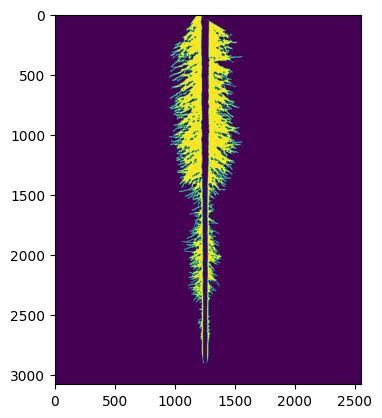

In [65]:
rh_mask_labeled, rh_count = label(rh_mask, connectivity=2, return_num=True)
rh_props = regionprops(rh_mask_labeled)
areas = [i.area for i in rh_props]

new_rh_mask = np.full(rh_mask.shape, fill_value=False) # create array of all False's of same shape as rh mask

if rh_count > 2:
    areas_reshaped = np.reshape(areas, (-1, 1)) # reshape areas for kmeans clustering

    kmeans_areas = KMeans(n_clusters=2).fit(areas_reshaped)
    # rh_to_ignore = areas[kmeans_areas.labels_ == 0] # areas of everything else to ignore
    main_rh_area = areas_reshaped[kmeans_areas.labels_ == 1] # area of main rh segments (either connected, as 1 area, or 2 large areas)
    
    for i in rh_props: # iterate over all regions
        for z in main_rh_area: # iterate over all areas in main_rh_area
            if i.area == z:
                new_rh_mask[rh_mask_labeled == i.label] = rh_mask[rh_mask_labeled == i.label]

    rh_mask = new_rh_mask

plt.imshow(rh_mask)

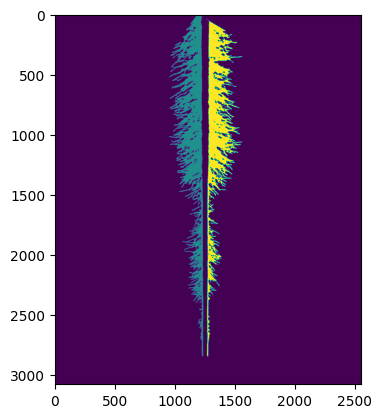

In [66]:
padding = 50

if found_tip:
    root_tip_y_max, root_tip_y_min = root_tip_y + padding, root_tip_y - padding
    root_tip_x_max, root_tip_x_min = root_tip_x + padding, root_tip_x - padding

    root_start_y_max, root_start_y_min = root_start_y + padding, root_start_y - padding
    root_start_x_max, root_start_x_min = root_start_x + padding, root_start_x - padding 

    rh_mask[root_tip_y_min:root_tip_y_max, root_tip_x_min:root_tip_x_max] = False # apply coords to mask
    rh_mask[root_start_y_min:root_start_y_max, root_start_x_min:root_start_x_max] = False

final_rh_mask_labeled, count = label(rh_mask, connectivity=2, return_num=True)



fig, ax = plt.subplots()
ax.imshow(final_rh_mask_labeled)

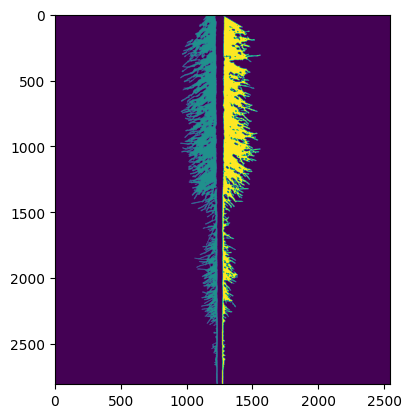

In [67]:
def get_region_coords(mask) -> list:

    props = regionprops(mask)
    coords = [i.coords for i in props]
    return coords

coords = get_region_coords(final_rh_mask_labeled)

crop_start = max(np.min(coords[0][:,0]), np.min(coords[1][:,0]))
cropped_rh_mask = final_rh_mask_labeled[crop_start:,:] # crop the final root hair section to the start of the shorter root hair segment for uniform calculation

coords = get_region_coords(cropped_rh_mask) # re-calculate coordinates of cropped image

crop_end = min(np.max(coords[0][:,0]), np.max(coords[1][:,0])) # crop ends of root hair sections
final_rh_mask = cropped_rh_mask[:crop_end, :]

plt.imshow(final_rh_mask)


In [68]:
root_hair_segment_props = regionprops(final_rh_mask)

root_hair_coords = [i.coords for i in root_hair_segment_props] # all coordinates of root hair segments
        
max_height = max(np.max(root_hair_coords[0][:,0]), np.max(root_hair_coords[1][:,0])) # get max height of root hair segment

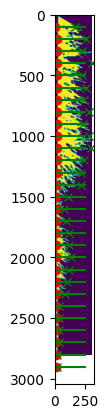

In [ ]:
height_bin_size = 100
horizontal_rh_list_1, horizontal_rh_list_2 = [], []
rh_area_list_1, rh_area_list_2 = [], []
bin_end_list_1, bin_end_list_2 = [], []
min_col_list_1, max_col_list_1 = [], []
min_col_list_2, max_col_list_2 = [], []

for index, segment in enumerate(root_hair_segment_props): # loop over each root hair section (left and right side)
    min_row, min_col, max_row, max_col = segment.bbox # calculate binding box coords of each segment
    segment_mask = final_rh_mask[min_row:max_row, min_col:max_col] # mask each root hair segment
    # segment_mask = remove_small_objects(segment_mask, connectivity=2, min_size=200)
    
    for bin_start in range(0, max_height, height_bin_size): # sliding window down each section

        bin_end = bin_start + height_bin_size # calculate bin end
        rh_segment = segment_mask[bin_start:bin_end, :] # define mask for sliding window for root hairs
        _, rh_segment_measured = clean_root_chunk(rh_segment) 
        rh_segment_area = [segment['area'] for segment in rh_segment_measured] # area of each segment
        
        for region in rh_segment_measured: # get 
            _, min_segment_col, _, max_segment_col = region.bbox 
            horizontal_rh_length = max_segment_col - min_segment_col 
            

        if index == 0:
            horizontal_rh_list_1.append(horizontal_rh_length)
            rh_area_list_1.append(rh_segment_area)
            bin_end_list_1.append(bin_end)
            min_col_list_1.append(min_segment_col)
            max_col_list_1.append(max_segment_col)
                
        elif index == 1:
            horizontal_rh_list_2.append(horizontal_rh_length)
            rh_area_list_2.append(rh_segment_area)
            bin_end_list_2.append(bin_end) 
            min_col_list_2.append(min_segment_col)
            max_col_list_2.append(max_segment_col)

bbox_list_1 = zip(min_col_list_1, min_col_list_2)
bbox_list_2 = zip(min_col_list_2, min_col_list_2)
 
plt.imshow(segment_mask)

for idx, point in enumerate(bin_end_list_1):
    plt.plot(min_col_list_2[idx], point, 'ro')
    plt.plot(max_col_list_2[idx], point, 'gx')
    plt.plot((0, max_col_list_2[idx]), (point, point), 'g-')
    # plt.plot(((point, min_col_list_2[idx]),(point, max_col_list_2[idx])), 'ro')


In [70]:
horizontal_rh_list_1

[96,
 130,
 159,
 163,
 236,
 138,
 116,
 219,
 210,
 226,
 200,
 181,
 174,
 230,
 270,
 240,
 218,
 234,
 243,
 277,
 267,
 216,
 216,
 217,
 154,
 214,
 184,
 92,
 99,
 86,
 22,
 93,
 109,
 69,
 85,
 112,
 126,
 174,
 152,
 118,
 112,
 106,
 116,
 103,
 124,
 97,
 82,
 32,
 32,
 25,
 48,
 30,
 24,
 25,
 11,
 12,
 8]